In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb;
import time
import copy

In [2]:
wheel_radius = 0.025
wheel_sep = 0.09
tail_dist = 0.075
robot_height = tail_dist  + wheel_radius

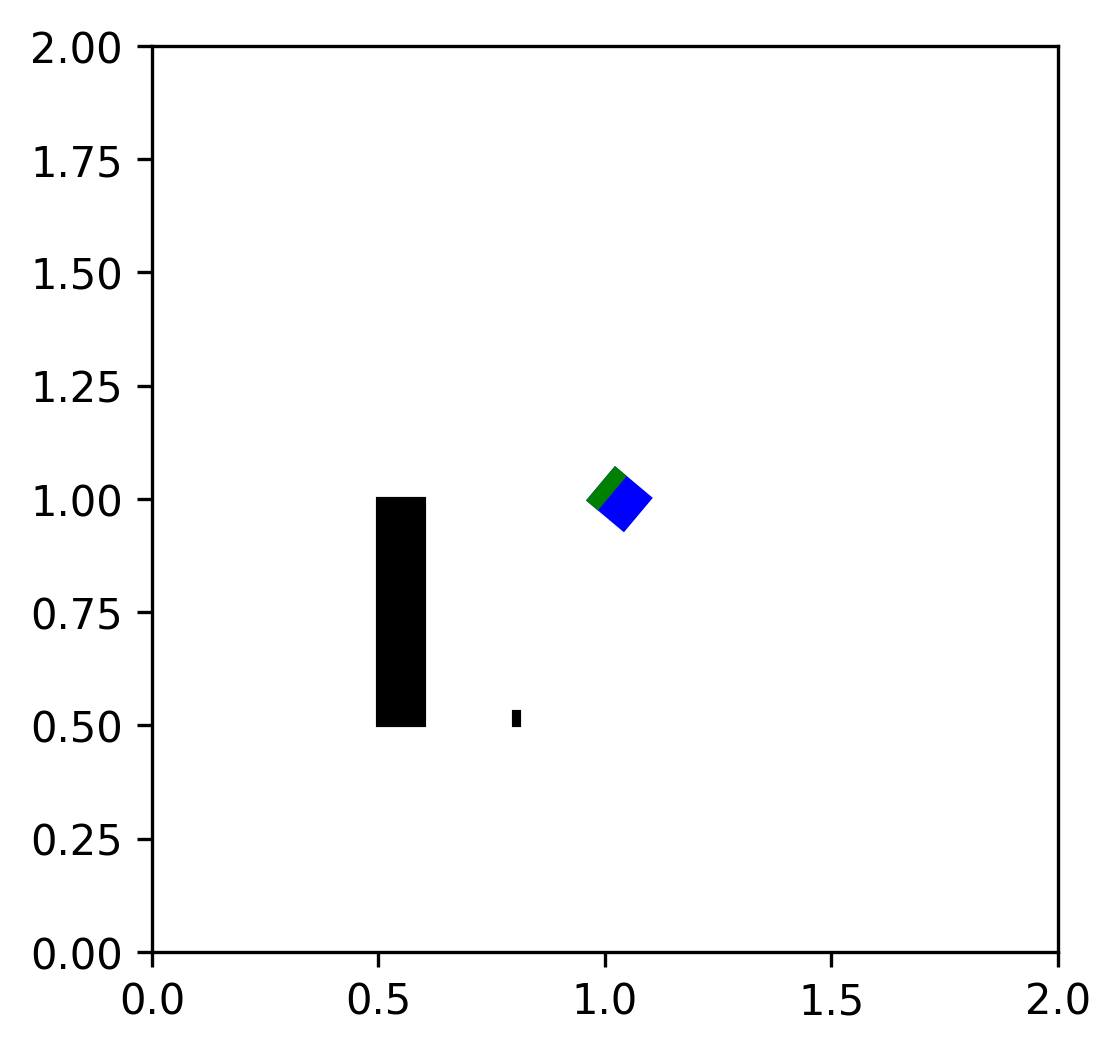

In [3]:
def show_world(obstacles = [[[0.5,0.5],[0.1,0.5]], [[0.8,0.5],[0.01,0.03]]],oneway = None,dimensions = [2,2]):
    plt.rcParams['figure.dpi'] = 300
    fig = plt.figure()
    ax=fig.add_subplot(111)
    plt.plot()
    
    for obstacle in obstacles:
        ax.add_patch(patches.Rectangle((obstacle[0][0],obstacle[0][1]),obstacle[1][0],obstacle[1][1],color='k'))

    if oneway is not None:
        for ow in oneway:
            ax.add_patch(patches.Rectangle((ow[0][0],ow[0][1]),ow[1][0],ow[1][1],color='y'))

    plt.axis([0,dimensions[0],0,dimensions[1]])
#         plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    return ax
        
#         plt.grid()

def plot_robot(rc,ax):       
    coords = [0.025,0.075]
    robot_dims = [0.05,0.1]
    tr = matplotlib.transforms.Affine2D().rotate_deg_around(rc[0],rc[1], 50) + ax.transData
    ax.add_patch(patches.Rectangle((rc[0]-coords[0],rc[1]-coords[1]),wheel_sep,robot_height,color='b',transform = tr))
    ax.add_patch(patches.Rectangle((rc[0]-coords[0],rc[1]),wheel_sep,wheel_radius,color='g',transform = tr))
            
  
ax = show_world()
plot_robot([1,1,np.pi/2],ax)



In [4]:
def get_angle_diff(a1,a2):
    ang_cw =  (a2 -a1)% (2*np.pi)
    ang_ccw = (- a2 + a1)% (2*np.pi)
    
    ang = np.minimum(ang_cw,ang_ccw) 
    if ang == ang_ccw:
        ang = - ang
    return ang

def get_dist_diff(c1,c2):
    dist = np.sqrt(((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2))
    return dist

def metric(c1,c2):
    dist = get_dist_diff(c1,c2)
    ang = get_angle_diff(c1[2],c2[2])
    
    rot_dist =  np.abs(ang) * wheel_radius
    
    metric = dist + rot_dist
    return metric
print(metric([1,1,0],[2,1,0]))

print(metric([1,1,0],[1,1,np.pi/4]))
print(metric([1,1,0],[1,1,-np.pi/4]))

1.0
0.019634954084936207
0.019634954084936207


In [5]:
w_wheel_rpm = 60
w_wheel = w_wheel_rpm * 2 * np.pi /60
v_wheel = w_wheel * wheel_radius

w_robot = v_wheel / (wheel_sep/2)
v_robot = v_wheel

print(v_robot,w_robot)



0.15707963267948966 3.490658503988659


In [6]:
def plan_trajectory(xi,xt):
    ang_points = np.pi/2 - np.arctan2(xt[1] - xi[1], xt[0] - xi[0])
    ang1 = get_angle_diff(xi[2],ang_points) 

    dist = get_dist_diff(xi,xt)
    print(xi,xt,dist)
    
    ang2 =  get_angle_diff(ang_points,xt[2])
    
    return [ang1,dist,ang2]
     
print(plan_trajectory([1,1,0],[1,2,0]))        
print(plan_trajectory([1,1,0],[1,0,-np.pi]))  
print(plan_trajectory([1,1,0],[2,2,-np.pi]))  

[1, 1, 0] [1, 2, 0] 1.0
[-0.0, 1.0, -0.0]
[1, 1, 0] [1, 0, -3.141592653589793] 1.0
[-3.141592653589793, 1.0, -0.0]
[1, 1, 0] [2, 2, -3.141592653589793] 1.4142135623730951
[0.7853981633974483, 1.4142135623730951, 2.356194490192345]


In [7]:
def time_trajectory(xi,xt):
    ang_points = np.pi/2 - np.arctan2(xt[1] - xi[1], xt[0] - xi[0])
    ang1 = get_angle_diff(xi[2],ang_points) 
    t = np.abs(ang1/w_robot)

    dist = get_dist_diff(xi,xt)
    t += np.abs(dist/v_robot)
    
    ang2 =  get_angle_diff(ang_points,xt[2])
    t += np.abs(ang2/w_robot)
    return [[ang1,dist,ang2],t]
     
print(time_trajectory([1,1,0],[1,2,0]))        
print(time_trajectory([1,1,0],[1,0,-np.pi]))  
print(time_trajectory([1,1,0],[2,2,-np.pi]))  

[[-0.0, 1.0, -0.0], 6.366197723675814]
[[-3.141592653589793, 1.0, -0.0], 7.266197723675814]
[[0.7853981633974483, 1.4142135623730951, 2.356194490192345], 9.903163161571062]


In [8]:
def execute_trajectory(xi,xt,duration = 1):
    t = 0
    ang1 = 0
    dist = 0
    ang2 = 0
    control_seq = [[0,0,0]]
    x_end = copy.deepcopy(xi)
    
    ang_points = np.pi/2 - np.arctan2(xt[1] - xi[1], xt[0] - xi[0])
    ang1 = get_angle_diff(xi[2],ang_points) 
    if ang1!=0:
        t_ang1 = np.abs(ang1/w_robot)
        t = t_ang1

        control_seq[-1][0] = np.sign(ang1) * w_wheel_rpm
        control_seq[-1][1] = -np.sign(ang1)*w_wheel_rpm
        if t_ang1>duration:
            ang1 = w_robot*duration*np.sign(ang1)
            control_seq[-1][2] = duration
            t = duration
            x_end[2] = ang1
            return [[ang1,dist,ang2],control_seq,x_end]
        else:
            control_seq[-1][2] = t_ang1
            t = t_ang1
            x_end[2] = ang1
            control_seq.append([0,0,0])
    
    dist = get_dist_diff(xi,xt)
    if dist!=0:
        t_dist = dist/v_robot

        control_seq[-1][0] = w_wheel_rpm
        control_seq[-1][1] = w_wheel_rpm
        if  t + t_dist>duration:
            dist = v_robot* (duration - t)
            x_end[0] += dist*np.cos(ang1)
            x_end[1] += dist*np.sin(ang1)
            t_dist = duration - t
            control_seq[-1][2] = t_dist
            return [[ang1,dist,ang2],control_seq,x_end]
        else:
            control_seq[-1][2] = t_dist
            t = t + t_dist
            x_end[0] += dist*np.cos(ang1)
            x_end[1] += dist*np.sin(ang1)
            control_seq.append([0,0,0])
    
    ang2 =  get_angle_diff(ang_points,xt[2])
    if ang2!=0:
        t_ang2 =  np.abs(ang1/w_robot)
        control_seq[-1][0] = np.sign(ang1) * w_wheel_rpm
        control_seq[-1][1] = -np.sign(ang1)*w_wheel_rpm
        if t + t_ang1>duration:
            ang2 = w_robot*np.sign(ang2)
            control_seq[-1][2] = duration - t
            x_end[2] = ang2
            t = duration
            return [[ang1,dist,ang2],control_seq,x_end]
        else:
            control_seq[-1][2] = t_ang2
            t = t + t_ang1
            x_end[2] = ang2
            control_seq.append([0,0,0])
            control_seq[-1][2] = duration - t

        
    return [[ang1,dist,ang2],control_seq,x_end]


print(time_trajectory([1,1,0],[1,1.1,0]))    
print(execute_trajectory([1,1,0],[1,1.1,0]))  

print()
print(time_trajectory([1,1,0],[1,0,-np.pi]))  
print(execute_trajectory([1,1,0],[1,0,-np.pi]))  

print()
print(time_trajectory([1,1,0],[2,2,-np.pi]))  
print(execute_trajectory([1,1,0],[2,2,-np.pi])) 

[[-0.0, 0.10000000000000009, -0.0], 0.6366197723675819]
[[-0.0, 0.10000000000000009, -0.0], [[60, 60, 0.6366197723675819], [0, 0, 0]], [1.1, 1.0, 0]]

[[-3.141592653589793, 1.0, -0.0], 7.266197723675814]
[[-3.141592653589793, 0.015707963267948963, 0], [[-60.0, 60.0, 0.9], [60, 60, 0.09999999999999998]], [0.984292036732051, 1.0, -3.141592653589793]]

[[0.7853981633974483, 1.4142135623730951, 2.356194490192345], 9.903163161571062]
[[0.7853981633974483, 0.12173671532660449, 0], [[60.0, -60.0, 0.225], [60, 60, 0.775]], [1.0860808569268183, 1.0860808569268183, 0.7853981633974483]]


In [9]:
# https://math.stackexchange.com/questions/261336/intersection-between-a-rectangle-and-a-circle

furthest_point_robot = np.sqrt((wheel_sep/2)**2+tail_dist**2)

def intersect_circle_segment(c,r,seg,vert):
    intersect = False
    xc,yc = c
    circ = lambda x,y: (x - xc)**2+(y-yc)**2 - r**2
    if vert:
        x = seg[0][0]
        y1 = seg[0][1]
        y2 = seg[1][1]
        if yc<y2 and yc>y1: 
            if np.abs(x-xc)<=r:
                intersect = True
        else:
            if circ(x,y1)<0 or circ(x,y2)<0:
                intersect = True
    else:
        y = seg[0][1]
        x1 = seg[0][0]
        x2 = seg[1][0]
        if xc<x2 and xc>x1: 
            if np.abs(y-yc)<=r:
                intersect = True
        else:
            if circ(x1,y)<0 or circ(x2,y)<0:
                intersect = True
    return intersect

def interset_circle_obstacle(c,r,obstacle):
    oc = obstacle[0]
    od = obstacle[1]
    rec_corn = [ [oc[0],oc[1]],[oc[0]+od[0],oc[1]],[oc[0]+od[0],oc[1]+od[1]],[oc[0],oc[1]+od[1]]]
#     import pdb; pdb.set_trace()
    intersect = False
    if c[0] > oc[0] and c[0] <= oc[0]+od[0] and c[1] > oc[0] and c[1]<=oc[1]+od[1]:
        intersect = True
    intersect = intersect or (intersect_circle_segment(c,r,[rec_corn[0],rec_corn[1]],False) or intersect_circle_segment(c,r,[rec_corn[1],rec_corn[2]],True)
        or intersect_circle_segment(c,r,[rec_corn[2],rec_corn[3]],False) or intersect_circle_segment(c,r,[rec_corn[0],rec_corn[3]],True))
    
    return intersect
    
interset_circle_obstacle([0,0],1,[[-2,-2],[5,5]])

True

In [10]:
def intersect_line_obstacle(xi,dist,theta,obstacle):
    theta = np.pi/2-theta
    intersect = False
    [[x1,y1],[tx,ty]] = obstacle
    x2 = x1+tx
    y2 = x1+ty
    get_dist_x = lambda x : (x - xi[0])/ np.cos(theta) 
    get_dist_y = lambda x : (x - xi[1])/ np.sin(theta)
    
    get_line_x = lambda d : xi[0] + d * np.cos(theta) 
    get_line_y = lambda d : xi[1] + d * np.sin(theta) 
    
    d_all = []
    
    d = get_dist_x(x1)
    if d>0 and d<dist:
        y = get_line_y(d)
        if y>= y1 and y<y2:
            intersect = True
            d_all.append(d)
    d = get_dist_x(x2)
    if d>0 and d<dist:  
        y = get_line_y(d)
        if y>= y1 and y<y2:
            intersect = True
            d_all.append(d)
    d = get_dist_y(y1)
    if d>0 and d<dist:
        x = get_line_x(d)
        if x>= x1 and x<x2:
            intersect = True
            d_all.append(d)
    d = get_dist_y(y2)
    if d>0 and d<dist:
        x = get_line_x(d)
        if x>= x1 and x<x2:
            intersect = True
            d_all.append(d)
    
    if intersect:
        d = np.min(d_all)
        

    return [intersect,d]
        
    
print(intersect_line_obstacle([0,0],10,0,[[-1,1],[5,5]]))
print(intersect_line_obstacle([0,0],10,np.pi/2,[[1,-1],[5,5]]))
print(intersect_line_obstacle([-0.5,0],10,0,[[-1,1],[1,1]]))

[True, 1.0]
[True, 1.0]
[True, 1.0]


/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [11]:
def check_path_for_collision(xi,path,obstacle):
    ang1,dist,ang2 = path
    
    x1 = [xi[0]+furthest_point_robot*np.sin(ang1), xi[1]+furthest_point_robot*np.cos(ang1)]
    x2 = [xi[0]-furthest_point_robot*np.sin(ang1), xi[1]-furthest_point_robot*np.cos(ang1)]
#     print(x1,x2)
    [collision1,d1] =  intersect_line_obstacle(x1,dist + furthest_point_robot,ang1,obstacle)
    [collision2,d2] =  intersect_line_obstacle(x2,dist + furthest_point_robot,ang1,obstacle)
    collision = collision1 or collision2
#     print(collision1,collision2)
    d_all = []
    if collision1:
        d_all.append(d1-furthest_point_robot)
    if collision2:
        d_all.append(d2-furthest_point_robot)
    max_d = -1
    if len(d_all)>0:
        max_d = np.min(d_all)
    
    return collision,max_d

check_path_for_collision ([0,0],[0,10,0], [[-1,1],[1,1]])

(False, -1)

In [12]:
  
xi = [0.7187956911325584, 0.4598020896321272, 2.7346964095217285]
xn = [0.6860780103414224, 0.5111037313722279, 2.138512503839758]
traj = [2.138512503839758, 0.06084657000670055, 0]
print(check_path_for_collision(xi,traj,obstacles_list[0]))

intersect_line_obstacle([0.6450518288868706, 0.5068323222606081],traj[1]+ furthest_point_robot,traj[0],obstacles_list[0])

NameError: name 'obstacles_list' is not defined

In [ ]:
def check_path_for_collisions(xi,path,obstacles):
    collision = False
    d_all = []
    for obstacle in obstacles:
#         print(obstacle)
        c,d = check_path_for_collision(xi,path,obstacle)  
        collision = c or collision
        if c:
            d_all.append(d)
    d = -1
    if collision:
        d = np.min(d_all)
    return collision,d
check_path_for_collisions ([0,0],[0,10,0], [ [[-1,1],[1,1]], [[-1,5],[1,1]] ])

In [ ]:
n_obstacles = 10
world_size = 2
np.random.seed(59711)
# obstacle_positions = np.random.uniform(0.2,world_size-0.2,[n_obstacles,2]).tolist()
# obstacle_dims = np.random.uniform(0.15,0.6,[n_obstacles,2]).tolist()

# obstacles_list = []
# for i in range(n_obstacles):
#     obstacles_list.append([obstacle_positions[i],obstacle_dims[i]])
obstacles_list= [[[0.5,0.5],[1,1]]]
    
ax = show_world(obstacles_list,dimensions=[world_size,world_size])
plot_robot([1,1,np.pi/2],ax)

In [ ]:
np.random.seed(0)
n_points = 1000
# ax = show_world(obstacles_list)
xi = [1,0.25,0]
V = [xi]
E = []
C = []
for i in range(n_points):
    xr = [np.random.uniform(0,world_size),np.random.uniform(0,world_size),np.random.uniform(0,2*np.pi)]
    d_min = 10000
#     print(xr)
    for x in V:
        d = metric(xr,x)
        if d < d_min:
            d_min = d
            x_min = x
    [traj,controls,x_new] = execute_trajectory(x_min,xr)
    collision,d = check_path_for_collisions(x_min,traj,obstacles)
    
    if not collision:
        
            
        V.append(x_new)
        E.append([x_min,x_new])
#         if x_new[0]>0.5 and x_new[0]<1.5 and x_new[1]>0.5 and x_new[1]<1.5:
#             print(x_min,x_new,traj, collision)
#             break
#         print(x,x_new,traj)
#         ae = np.array([x,x_new])
#         ax = show_world(obstacles_list)
#         plt.plot(ae[:,0],ae[:,1],'b')
#         plt.show()
ax = show_world(obstacles_list)      
for e in E:
    ae = np.array(e)
    plt.plot(ae[:,0],ae[:,1],'b',linewidth =0.1)

(False, -1)

[[[ 1.          0.25        0.        ]
  [ 0.98149925  0.17710153 -1.81933692]]

 [[ 0.98149925  0.17710153 -1.81933692]
  [ 1.13209331  0.29931819  0.35733093]]

 [[ 1.13209331  0.29931819  0.35733093]
  [ 0.94819109  0.12741331 -2.16133989]]

 [[ 0.94819109  0.12741331 -2.16133989]
  [ 1.27265946  0.26205999 -0.25909998]]

 [[ 1.27265946  0.26205999 -0.25909998]
  [ 1.24017031  0.27793422  2.6871059 ]]

 [[ 1.24017031  0.27793422  2.6871059 ]
  [ 1.3724712   0.34067918  0.66718024]]

 [[ 1.3724712   0.34067918  0.66718024]
  [ 1.01550869  0.22020322  0.94317097]]]


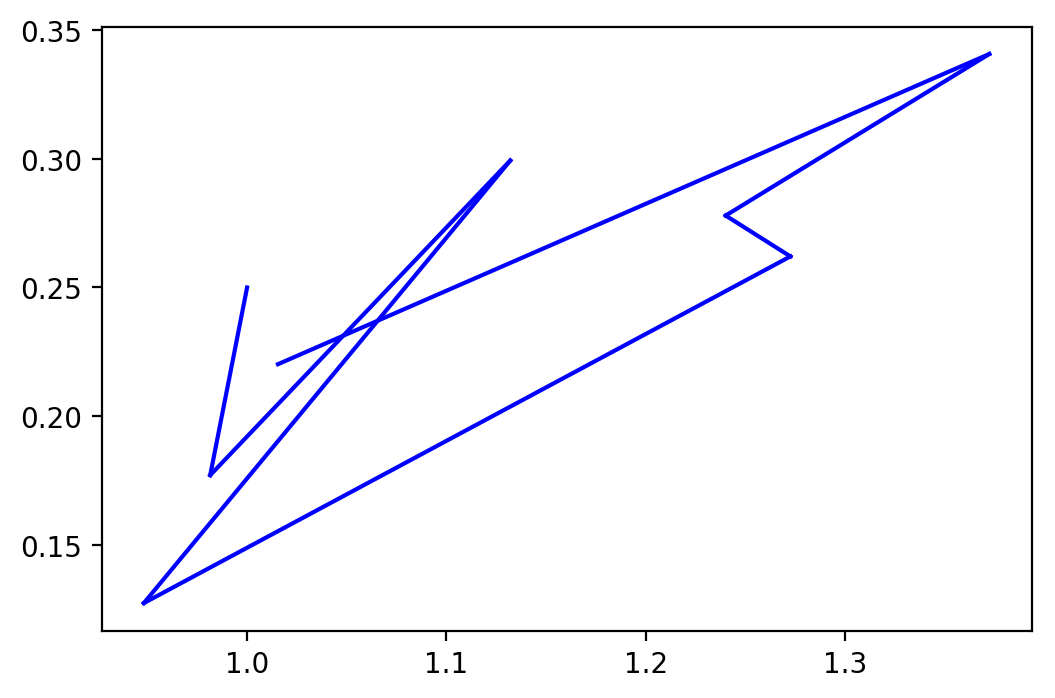

In [333]:
print(np.array(E))
for e in E:
    ae = np.array(e)
    plt.plot(ae[:,0],ae[:,1],'b')

In [175]:
for _ in range(100):
    print()